This assignment is taken from Svetlana Lazebnik.

### Common imports

In [21]:
%matplotlib inline
import os
import sys
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

### Provided functions
#### Image loading and saving

In [22]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

In [23]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

#### Plot the albedo and the surface norms. 

In [24]:
def plot_albedo_and_surface_normals(albedo_image, surface_normals):
    """
    albedo_image: h x w matrix
    surface_normals: h x w x 3 matrix.
    """
    fig, axes = plt.subplots(1, 4, figsize=(10,2.5))
    ax = axes[0]
    ax.axis('off')
    ax.set_title('albedo')
    ax.imshow(albedo_image, cmap='gray')

    ax = axes[1]
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0], cmap='jet')
    ax = axes[2]
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1], cmap='jet')
    ax = axes[3]
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2], cmap='jet')

    fig.colorbar(im, ax=axes, fraction=0.02, aspect=15)

#### Plot the height map

In [25]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])

def display_3d(albedo_image, height_map, elev, azim):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.view_init(elev, azim)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

---
### Your implementation

In [26]:
def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """
    subtracted = imarray - ambimage[:,:,np.newaxis]
    clipped = subtracted.clip(min=0)
    processed_imarray = clipped/255
    return processed_imarray

In [27]:
def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    h = len(imarray)
    w = len(imarray[0])
    Nimages = len(imarray[0][0])
    
    dim = 3
    reverse1 = (2,0,1)
    reverse2 = (1,2,0)
    imarray = np.reshape(np.transpose(imarray,reverse1),(Nimages, h*w))
    g, residuals, rank, s = np.linalg.lstsq(light_dirs,imarray, rcond= None)
    print(sum(residuals)/(h*w*Nimages))
    mag_g = np.linalg.norm(g, axis = 0)
    albedo_image = np.reshape(mag_g, (h, w))
    surface_normals = np.transpose(np.reshape(g/mag_g,(3,h,w)),reverse2)
    return albedo_image, surface_normals

In [28]:
def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals:h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
    """
    
    h = len(surface_normals)
    w = len(surface_normals[0])
    g1 = surface_normals[:,:,0]
    g2 = surface_normals[:,:,1]
    g3 = surface_normals[:,:,2]
    f_x = g1/g3
    f_y = g2/g3
    #cumsum axis = 0, integrate col, axis = 1 integrate row
    if integration_method == 'row':
        row_0 = np.array([np.cumsum(f_x[0])])
        row_rest = f_y[1:h]    
        array = np.concatenate((row_0,row_rest), axis = 0)
        height_map = np.cumsum(array, axis = 0)
        
    elif integration_method == 'column':
        col_0 = np.array([np.cumsum(f_y[:,0])]).reshape(192,1)
        col_rest = f_x[:,1:w]
        array = np.concatenate((col_0,col_rest), axis = 1)
        height_map = np.cumsum(array, axis = 1)
        
    elif integration_method == 'average':
        row_0 = np.array([np.cumsum(f_x[0])])
        row_rest = f_y[1:h]    
        array = np.concatenate((row_0,row_rest), axis = 0)
        height_map_row = np.cumsum(array, axis = 0)
        col_0 = np.array([np.cumsum(f_y[:,0])]).reshape(192,1)
        col_rest = f_x[:,1:w]
        array = np.concatenate((col_0,col_rest), axis = 1)
        height_map_column = np.cumsum(array, axis = 1)
        height_map = (height_map_row + height_map_column) / 2
    else:
        num_path = 10
        height_map = np.zeros((h,w))
        for row in range(h):
            for col in range(w):
                for k in range(num_path):
                    total, i,j = 0, 0,0
                    while(i < row or j < col):
                        rand = np.random.randint(2)
                        if i >= row:
                            rand = 1
                        if j >= col:
                            rand = 0 
                        if rand:
                            total += f_x[i,j]
                            j += 1
                        else:
                            total += f_y[i,j] 
                            i += 1
                    height_map[row, col] += total
        height_map = height_map/num_path
                
    return height_map

### Main function

In [34]:
import time
root_path = './croppedyale1/'
subject_name = 'yaleB02'
integration_method = 'average'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                    64)


processed_imarray = preprocess(ambient_image, imarray)
albedo_image, surface_normals = photometric_stereo(processed_imarray, light_dirs)
#start= time.clock()
height_map = get_surface(surface_normals, integration_method)
#print(time.clock() - start)
if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

Total available images is less than specified.
Proceeding with 54 images.

0.02293486206186059


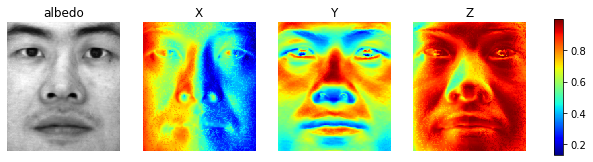

In [35]:
plot_albedo_and_surface_normals(albedo_image, surface_normals)

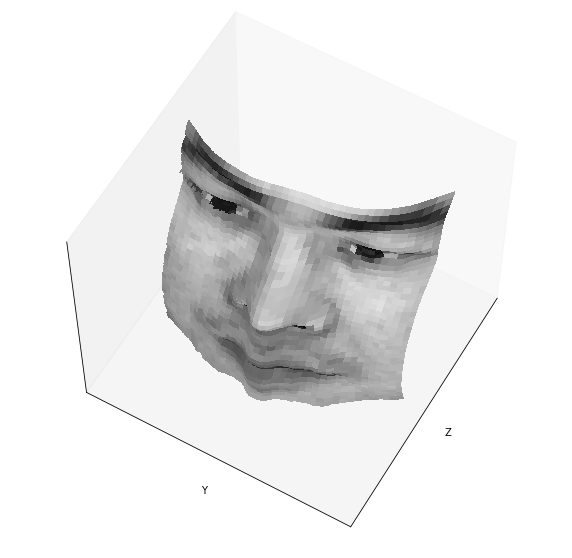

In [36]:
display_3d(albedo_image, height_map, 60, 30)